In [1]:
#Taken from sccloud
import numpy as np
import pandas as pd
import time
from natsort import natsorted
import multiprocessing
from sklearn.cluster import KMeans
import scanpy as sc
import os
import sys


def estimate_background_probs(adt, random_state = 0):
	adt.obs['counts'] = adt.X.sum(axis = 1).A1 if adt.shape[1] > 1 else adt.X
	counts_log10 = np.log10(adt.obs['counts'].values.reshape(-1, 1))
	kmeans = KMeans(n_clusters = 2, random_state = random_state).fit(counts_log10)
	signal = 0 if kmeans.cluster_centers_[0] > kmeans.cluster_centers_[1] else 1
	adt.obs['hto_type'] = 'background'
	adt.obs.loc[kmeans.labels_ == signal, 'hto_type'] = 'signal'

	idx = np.isin(adt.obs['hto_type'], 'background')
	pvec = adt.X[idx,].sum(axis = 0).A1 if adt.shape[1] > 1 else np.array(adt.X[idx,].sum())
	pvec /= pvec.sum()

	adt.uns['background_probs'] = pvec



def estimate_probs(arr, pvec, alpha, alpha_noise, tol):
	probs = np.zeros(pvec.size + 1)
	old_probs = np.zeros(pvec.size + 1)
	z = np.zeros(pvec.size + 1)
	noise = pvec.size
	# Estimate MLE without Generalized Dirichlet prior
	probs_mle = arr / arr.sum()
	probs[noise] = (probs_mle / pvec).min() + 0.01
	probs[:-1] = np.maximum(probs_mle - probs[noise] * pvec, 0.01)
	probs = probs / probs.sum()

	# EM algorithm
	i = 0
	eps = 1.0
	while eps > tol:
		i += 1
		old_probs[:] = probs[:]
		# E step
		z[:-1] = alpha - 1.0
		z[noise] = alpha_noise - 1.0
		for j in range(pvec.size):
			if arr[j] > 0:
				p = probs[j] / (probs[noise] * pvec[j] + probs[j])
				z[j] += arr[j] * p
				z[noise] += arr[j] * (1.0 - p)
		# M step
		idx = z > 0.0
		probs[idx] = z[idx] / z[idx].sum()
		probs[~idx] = 0.0
		eps = np.linalg.norm(probs - old_probs, ord = 1)
		# print ("i = {}, eps = {:.2g}.".format(i, eps))

	return probs



def get_droplet_info(probs, sample_names):
	ids = np.nonzero(probs >= 0.1)[0]
	ids = ids[np.argsort(probs[ids])[::-1]]
	return ('singlet' if ids.size == 1 else 'doublet',
			','.join([sample_names[i] for i in ids]))

def calc_demux(data, adt, nsample, min_signal, probs = 'raw_probs'):
	demux_type = np.full(data.shape[0], 'unknown', dtype = 'object')
	assignments = np.full(data.shape[0], '', dtype = 'object')

	signals = adt.obs['counts'].reindex(data.obs_names, fill_value = 0.0).values * (1.0 - data.obsm[probs][:,nsample])
	idx = signals >= min_signal

	tmp = data.obsm[probs][idx,]
	norm_probs = tmp[:,0:nsample] / (1.0 - tmp[:,nsample])[:,None]

	values1 = []
	values2 = []
	for i in range(norm_probs.shape[0]):
		droplet_type, droplet_id = get_droplet_info(norm_probs[i,], adt.var_names)
		values1.append(droplet_type)
		values2.append(droplet_id)

	demux_type[idx] = values1
	data.obs['demux_type'] = pd.Categorical(demux_type, categories = ['singlet', 'doublet', 'unknown'])
	assignments[idx] = values2
	data.obs['assignment'] = pd.Categorical(assignments, categories = natsorted(np.unique(assignments)))



def demultiplex(data, adt, min_signal = 10.0, alpha = 0.0, alpha_noise = 1.0, tol = 1e-6, n_threads = 1):
	start = time.time()
	
	nsample = adt.shape[1]
	data.uns['background_probs'] = adt.uns['background_probs']

	idx_df = data.obs_names.isin(adt.obs_names)
	adt.obs['rna_type'] = 'background'
	adt.obs.loc[data.obs_names[idx_df], 'rna_type'] = 'signal'

	if nsample == 1:
		print("Warning: detect only one barcode, no need to demultiplex!")
		data.obsm['raw_probs'] = np.zeros((data.shape[0], nsample + 1))
		data.obsm['raw_probs'][:, 0] = 1.0
		data.obsm['raw_probs'][:, 1] = 0.0
		data.obs['demux_type'] = 'singlet'
		data.obs['assignment'] = adt.var_names[0]
	else:
		if nsample == 2:
			print("Warning: detect only two barcodes, demultiplexing accuracy might be affected!")

		ncalc = idx_df.sum()
		if ncalc < data.shape[0]:
			nzero = data.shape[0] - ncalc
			print("Warning: {} cells do not have ADTs, percentage = {:.2f}%.".format(nzero, nzero * 100.0 / data.shape[0]))
		adt_small = adt[data.obs_names[idx_df],].X.toarray()

		data.obsm['raw_probs'] = np.zeros((data.shape[0], nsample + 1))
		data.obsm['raw_probs'][:, nsample] = 1.0

		iter_array = [(adt_small[i,], adt.uns['background_probs'], alpha, alpha_noise, tol) for i in range(ncalc)]
		with multiprocessing.Pool(n_threads) as pool:
			data.obsm['raw_probs'][idx_df, :] = pool.starmap(estimate_probs, iter_array)

		calc_demux(data, adt, nsample, min_signal)
	
	end = time.time()
	print("demuxEM.demultiplex is finished. Time spent = {:.2f}s.".format(end - start))

In [2]:
multiseqdata=sc.read_10x_mtx('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E90-2019_Multi-seq_kOut/multiseq_outs',gex_only=False)


In [3]:
adata=sc.read_10x_mtx('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E90-2019_Multi-seq_kOut/all/')

/wynton/home/ye/mschmitz1/utils/miniconda3/envs/multiseq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [4]:
adata=adata[adata.obs.index.isin(multiseqdata.obs.index),:]
multiseqdata=multiseqdata[multiseqdata.obs.index.isin(adata.obs.index),:]


In [5]:
estimate_background_probs(multiseqdata)
demultiplex(adata,multiseqdata,min_signal=5.0,alpha=0.1,alpha_noise=1.0)
print(adata.obs['assignment'].value_counts())
adata.obs.loc[:,['demux_type','assignment']]

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
/wynton/home/ye/mschmitz1/utils/miniconda3/envs/multiseq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


demuxEM.demultiplex is finished. Time spent = 347.59s.
E90-2019_Hypothalamus                                1079
                                                      696
E90-2019_Choroid                                      631
E90-2019_V1                                           594
E90-2019_PFC                                          573
                                                     ... 
E90-2019_Pons,E90-2019_Choroid,E90-2019_CGE             1
E90-2019_Hypothalamus,E90-2019_Hippo,E90-2019_V1        1
E90-2019_Hypothalamus,E90-2019_Hippo,E90-2019_...       1
E90-2019_Hypothalamus,E90-2019_Hippo,E90-2019_...       1
E90-2019_MGE,E90-2019_PFC,E90-2019_Hippo                1
Name: assignment, Length: 1093, dtype: int64


,demux_type,assignment
AAACCCAAGAGTCCGA,doublet,"E90-2019_Choroid,E90-2019_Temporal"
AAACCCAAGATAGTCA,doublet,"E90-2019_Hippo,E90-2019_MGE,E90-2019_Motor_1"
AAACCCAAGATGTTAG,doublet,"E90-2019_Temporal,E90-2019_LGE"
AAACCCAAGCCTCTTC,doublet,"E90-2019_Choroid,E90-2019_Temporal"
AAACCCAAGTCCGCCA,singlet,E90-2019_E80Cultured
...,...,...
TTTGTTGTCAACGAGG,unknown,
TTTGTTGTCACTCACC,doublet,"E90-2019_Pons,E90-2019_Temporal,E90-2019_V1"
TTTGTTGTCCATGAGT,unknown,
TTTGTTGTCCGGCAAC,unknown,


In [6]:
min_genes=700

/wynton/home/ye/mschmitz1/utils/miniconda3/envs/multiseq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 12695 × 97895
    obs: 'demux_type', 'assignment', 'percent_ribo', 'percent_mito'
    var: 'gene_ids', 'feature_types'
    uns: 'background_probs'
    obsm: 'raw_probs'


/wynton/home/ye/mschmitz1/utils/miniconda3/envs/multiseq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/wynton/home/ye/mschmitz1/utils/miniconda3/envs/multiseq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 12664 × 97844
    obs: 'demux_type', 'assignment', 'percent_ribo', 'percent_mito'
    var: 'gene_ids', 'feature_types'
    uns: 'background_probs'
    obsm: 'raw_probs'


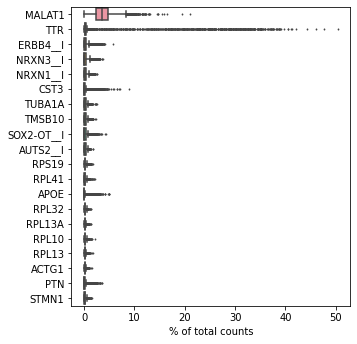

AnnData object with n_obs × n_vars = 12111 × 43534
    obs: 'demux_type', 'assignment', 'percent_ribo', 'percent_mito', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'background_probs'
    obsm: 'raw_probs'


/wynton/home/ye/mschmitz1/utils/miniconda3/envs/multiseq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/wynton/home/ye/mschmitz1/utils/miniconda3/envs/multiseq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/wynton/home/ye/mschmitz1/utils/miniconda3/envs/multiseq/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


ImportError: Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`.

In [8]:
adata.raw=adata
adata.var_names_make_unique()
ribo_genes=[name for name in adata.var_names if name.startswith('RPS') or name.startswith('RPL') ]
adata.obs['percent_ribo'] = np.sum(
adata[:, ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)
mito_genes = [name for name in adata.var_names if name in ['ND1','ND2','ND4L','ND4','ND5','ND6','ATP6','ATP8','CYTB','COX1','COX2','COX3'] or name.startswith('chrM-') or name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(
adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
print(adata)


#adata=adata[adata.obs['percent_ribo']<.5,:]
#adata=adata[adata.obs['percent_ribo']<.2,:]
adata._inplace_subset_obs(adata.obs['percent_ribo']<.4)
adata._inplace_subset_obs(adata.obs['percent_mito']<.15)
adata._inplace_subset_var(~adata.var.index.isin(mito_genes))
print(adata)
sc.pp.filter_genes(adata,min_cells=10)
#sc.pp.filter_cells(adata,min_counts=1000)
sc.pp.filter_cells(adata,min_genes=min_genes)
sc.pl.highest_expr_genes(adata, n_top=20, )
print(adata)
sc.pp.normalize_total(adata,exclude_highly_expressed=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=6000,subset=False)
sc.pp.scale(adata,max_value=10)
sc.pp.pca(adata,n_comps=100)
sc.pp.neighbors(adata)
#bbknn.bbknn(adata,batch_key='batch_name',n_pcs=100,neighbors_within_batch=3)


/wynton/home/ye/mschmitz1/utils/miniconda3/envs/multiseq/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


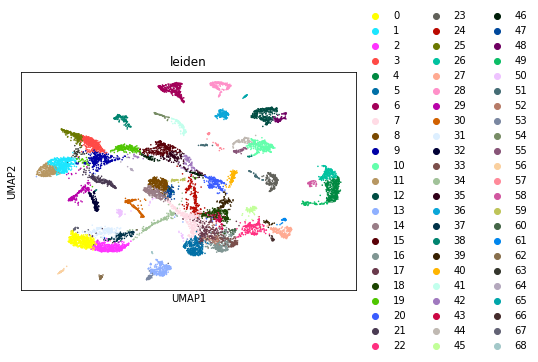

In [9]:
sc.tl.leiden(adata,resolution=4)
sc.tl.umap(adata,spread=2)
sc.pl.umap(adata,color=['leiden'])

In [17]:
adata.obs.loc[adata.obs['demux_type']=='singlet','region']=adata.obs['assignment'][adata.obs['demux_type']=='singlet']

/wynton/home/ye/mschmitz1/utils/miniconda3/envs/multiseq/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'region' as categorical


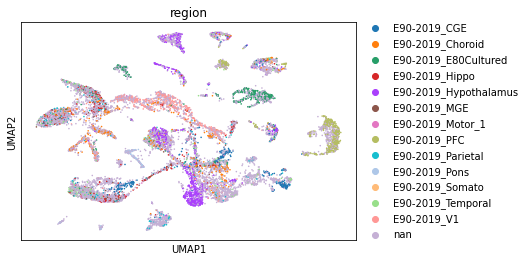

In [19]:
sc.pl.umap(adata,color=['region'])

In [ ]:
for alpha in [0.0,.5,1,5]:
    for alpha_noise in [.5,1,4,10]:
        print(alpha,alpha_noise)
        demultiplex(adata,multiseqdata,min_signal=15.0,alpha=alpha,alpha_noise=alpha_noise)
        try:
            print(adata.obs['assignment'].value_counts())
            print(adata.obs['assignment'].value_counts()['E90-2019_CGE'])
            print(adata.obs['assignment'].value_counts()['E90-2019_Septum'])
        except:
            pass


0.0 0.5


<ipython-input-3-e87e60e3af01>:49: RuntimeWarning: invalid value encountered in double_scalars
  p = probs[j] / (probs[noise] * pvec[j] + probs[j])


demuxEM.demultiplex is finished. Time spent = 192.58s.
E90-2019_Hypothalamus                                1035
                                                      785
E90-2019_PFC                                          487
E90-2019_Choroid                                      414
E90-2019_CGE                                          394
                                                     ... 
E90-2019_Temporal,E90-2019_Hypothalamus,E90-20...       1
E90-2019_Temporal,E90-2019_Hypothalamus,E90-20...       1
E90-2019_Hypothalamus,E90-2019_Parietal,E90-20...       1
E90-2019_Temporal,E90-2019_Hypothalamus,E90-20...       1
E90-2019_Hypothalamus,E90-2019_V1,E90-2019_Cho...       1
Name: assignment, Length: 1460, dtype: int64
394
0.0 1
demuxEM.demultiplex is finished. Time spent = 299.66s.
                                                     1336
E90-2019_Hypothalamus                                1059
E90-2019_Choroid                                      602
E90-2019_V1            

In [ ]:
adata.obs['demux_type'].value_counts()

In [50]:
import os
multiseq=pd.read_csv(os.path.join('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E80-2019_Multi-seq_kOut','multiseq_calls.csv'),index_col=0)


In [53]:
multiseq=multiseq.loc[multiseq['demux_type']=='singlet',:]

In [54]:
[sc_utils.region_format_macaque(x) for x in multiseq['assignment']]

,demux_type,assignment
AAACCCAAGCGACTAG,singlet,E80-2019_Temporal
AAACCCAAGCTCCGAC,singlet,E80-2019_PFC
AAACCCAAGGCGCTTC,singlet,E80-2019_V1
AAACCCACAATTAGGA,singlet,E80-2019_Somato
AAACCCACATCCGTGG,singlet,E80-2019_V1
...,...,...
TTGTTGTAGGAAGTCC,singlet,E80-2019_Motor_1
TTTCGATAGCAGGTCA,singlet,E80-2019_Motor_1
TTTGACTAGGCATCTT,singlet,E80-2019_Cerebellum
TTTGGAGAGACTGGGT,singlet,E80-2019_Cerebellum


In [3]:
df=pd.read_csv('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_kallisto/E90-2019_Multi-seq_kOut/MULTIseq_counts.txt',sep='\t')

<AxesSubplot:xlabel='E90-2019_Septum'>

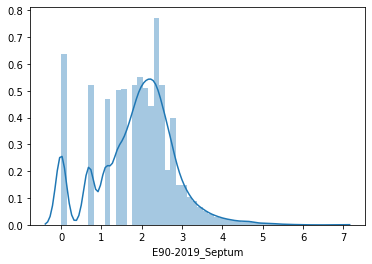

In [9]:
df['E90-2019_Parietal']
seaborn.distplot(np.log(df['E90-2019_Septum']+1))

<AxesSubplot:xlabel='E90-2019_Parietal'>

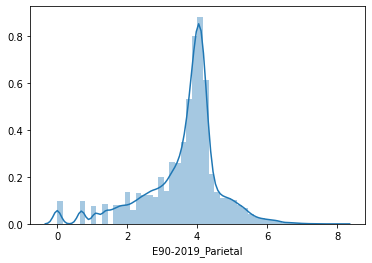

In [10]:
seaborn.distplot(np.log(df['E90-2019_Parietal']+1))

<AxesSubplot:xlabel='E90-2019_PFC'>

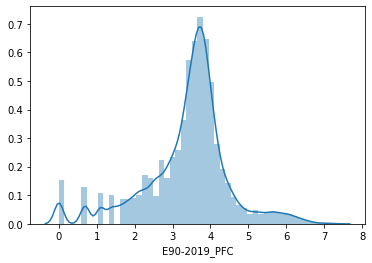

In [11]:
seaborn.distplot(np.log(df['E90-2019_PFC']+1))

<AxesSubplot:xlabel='E90-2019_Parietal', ylabel='E90-2019_Septum'>

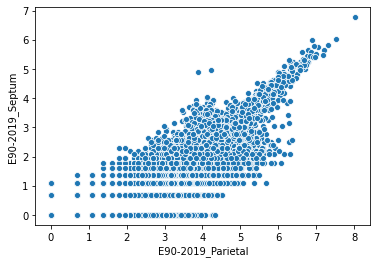

In [12]:
seaborn.scatterplot(np.log(df['E90-2019_Parietal']+1),np.log(df['E90-2019_Septum']+1))